In [1]:
# ---------------------导入相应的数据库--------------------- #
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import xlrd
from matplotlib import rcParams

In [2]:
# ---------------------定义整体的神经网络--------------------- #
# PyTorch Neural Network Model
class NeuralNet(nn.Module):
    def __init__(self, layers):
        super(NeuralNet, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
        
    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = torch.tanh(self.layers[i](x))
        x = self.layers[-1](x)  # Last layer without activation
        return x

In [3]:
# ---------------------定义整体的数据和训练模型--------------------- #

# PINN Model Class
class PINN_model:
    def __init__(self, layers, X, q, X_uc, u_c, X_ac, a_c, X_kc, k_c):
        # 采用GPU 加速计算
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 将数据转化为统一类型方便运算
        self.X = torch.tensor(X, dtype=torch.float32).to(self.device)
        self.q = torch.tensor(q, dtype=torch.float32).to(self.device)
        self.X_uc = torch.tensor(X_uc, dtype=torch.float32).to(self.device)
        self.u_c = torch.tensor(u_c, dtype=torch.float32).to(self.device)
        self.X_ac = torch.tensor(X_ac, dtype=torch.float32).to(self.device)
        self.a_c = torch.tensor(a_c, dtype=torch.float32).to(self.device)
        self.X_kc = torch.tensor(X_kc, dtype=torch.float32).to(self.device)
        self.k_c = torch.tensor(k_c, dtype=torch.float32).to(self.device)

        # Initialize networks
        self.net_u = NeuralNet(layers[0]).to(self.device)
        self.net_a = NeuralNet(layers[1]).to(self.device)
        self.net_k = NeuralNet(layers[2]).to(self.device)
        self.net_Q = NeuralNet(layers[3]).to(self.device)

        # Optimizer
        self.optimizer = optim.Adam(self.get_params(), lr=1e-3)
        self.EI = 1.0  # Material property

        # Loss Logs
        self.loss_log = []
        self.loss_c_log = []
        self.loss_f_log = []

    # 将Network其中的参数传递给优化器，这里代表的是各个模型中的参数
    def get_params(self):
        return list(self.net_u.parameters()) + list(self.net_a.parameters()) + \
               list(self.net_k.parameters()) + list(self.net_Q.parameters())

    # 定义了求道的参数x
    def net_f(self, x):
        x.requires_grad = True
        Q = self.net_Q(x)  # 剪力
        k = self.net_k(x)  # 曲率，是为了后面计算弯矩
        a = self.net_a(x)  # 角度
        u = self.net_u(x)  # 位移
        
        # 计算弯矩
        M = self.EI * k

        # Gradients，求导，各个参数之间的导数关系，这里就可以体现出来
        # 剪力的导数 --> 载荷集度 q
        Q_x = torch.autograd.grad(Q, x, 
                                  grad_outputs=torch.ones_like(Q), 
                                  create_graph=True, 
                                  retain_graph=True)[0]
        # 弯矩的导数 --> 剪力 Q
        M_x = torch.autograd.grad(M, x, 
                                  grad_outputs=torch.ones_like(M), 
                                  create_graph=True, 
                                  retain_graph=True)[0]
        # 转角 a 的导数 --> 曲率 k
        a_x = torch.autograd.grad(a, x, 
                                  grad_outputs=torch.ones_like(a), 
                                  create_graph=True, 
                                  retain_graph=True)[0]
        # u_x：位移的导数 --> 转角 a
        u_x = torch.autograd.grad(u, x, 
                                  grad_outputs=torch.ones_like(u), 
                                  create_graph=True, 
                                  retain_graph=True)[0]

        # 导数之间的关系，也就是控制方程之间的联系a  u k Q 的关系，最后根据关系得到损失函数的值为多少
        f_Q_q = Q_x + self.q
        f_M_Q = M_x - Q
        f_a_k = a_x + k
        f_u_k = u_x - a

        # 返回的是损失函数的值，也就是实际的方程的值
        return f_Q_q, f_M_Q, f_a_k, f_u_k

    def train(self, nIter=10000):
        # Training loop 对于模型构建好，后面开始进行训练了
        for it in range(nIter):
            self.optimizer.zero_grad()
            
            # Compute losses 将训练的模型的数据进行预测，得到预测值
            u_c_pred = self.net_u(self.X_uc)
            a_c_pred = self.net_a(self.X_ac)
            k_c_pred = self.net_k(self.X_kc)

            # 得到各个导数的值进行分析
            f_Q_q, f_M_Q, f_a_k, f_u_k = self.net_f(self.X)

            # 计算出来的导数，根据物理方程的关系，计算他们之间损失函数的值
            # 一个是物理方程的损失函数，一个是边界条件的损失函数，还有数据的损失函数
            
            # -----------------损失函数的定义------------------- #
            loss_c = torch.mean((u_c_pred - self.u_c) ** 2) + torch.mean((k_c_pred - self.k_c) ** 2)
            loss_f = torch.mean(f_Q_q ** 2) + torch.mean(f_M_Q ** 2) + torch.mean(f_a_k ** 2) + torch.mean(f_u_k ** 2)
            loss = loss_c + loss_f
            ##---------------------------------------------------------------------------------------###

            # 误差反向传播，将误差值对梯度进行下降处理
            loss.backward()
            # 更新 Network 的参数
            self.optimizer.step()

            # Logging，记录反向传播的误差值，记录训练的次数，以及损失函数的值
            self.loss_log.append(loss.item())
            self.loss_c_log.append(loss_c.item())
            self.loss_f_log.append(loss_f.item())

            # 根据训练到达的次数，打印出训练的次数，以及损失函数的值
            if it % 100 == 0:
                print(f"Iter {it}, Loss_c: {loss_c:.3e}, Loss_f: {loss_f:.3e}, Total Loss: {loss:.3e}")

    # 根据训练的模型进行相关值的预测，返回预测值
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            u = self.net_u(x).cpu().numpy()
            a = self.net_a(x).cpu().numpy()
            k = self.net_k(x).cpu().numpy()
            Q = self.net_Q(x).cpu().numpy()
        return Q, k, a, u

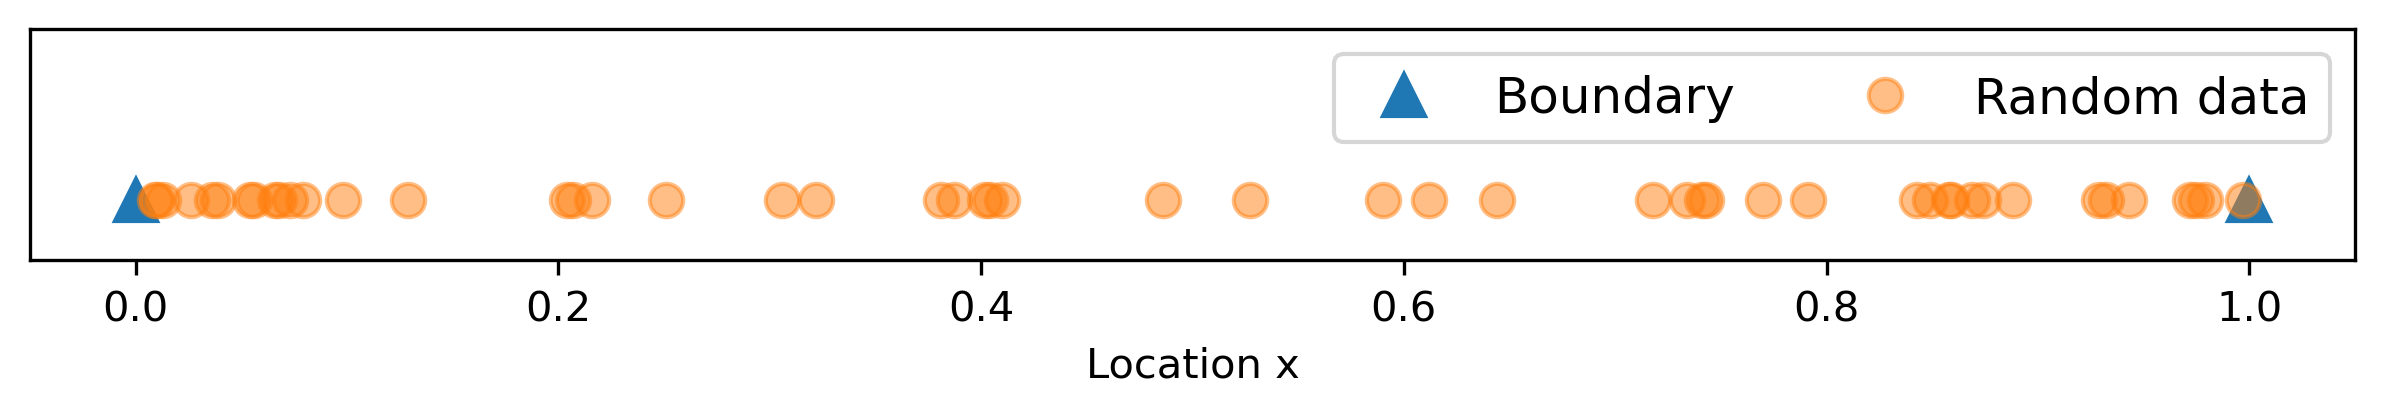

Iter 0, Loss_c: 6.271e-01, Loss_f: 1.368e-01, Total Loss: 7.639e-01
Iter 100, Loss_c: 1.972e-02, Loss_f: 9.172e-02, Total Loss: 1.114e-01
Iter 200, Loss_c: 1.381e-03, Loss_f: 1.186e-02, Total Loss: 1.324e-02
Iter 300, Loss_c: 3.258e-04, Loss_f: 5.752e-03, Total Loss: 6.078e-03
Iter 400, Loss_c: 9.167e-05, Loss_f: 2.865e-03, Total Loss: 2.957e-03
Iter 500, Loss_c: 3.592e-05, Loss_f: 1.650e-03, Total Loss: 1.686e-03
Iter 600, Loss_c: 1.913e-05, Loss_f: 1.231e-03, Total Loss: 1.250e-03
Iter 700, Loss_c: 1.124e-05, Loss_f: 1.016e-03, Total Loss: 1.027e-03
Iter 800, Loss_c: 6.521e-06, Loss_f: 8.352e-04, Total Loss: 8.417e-04
Iter 900, Loss_c: 3.643e-06, Loss_f: 6.648e-04, Total Loss: 6.684e-04
Iter 1000, Loss_c: 1.956e-06, Loss_f: 5.062e-04, Total Loss: 5.082e-04
Iter 1100, Loss_c: 1.011e-06, Loss_f: 3.649e-04, Total Loss: 3.660e-04
Iter 1200, Loss_c: 5.059e-07, Loss_f: 2.468e-04, Total Loss: 2.473e-04
Iter 1300, Loss_c: 2.436e-07, Loss_f: 1.524e-04, Total Loss: 1.526e-04
Iter 1400, Loss_c:

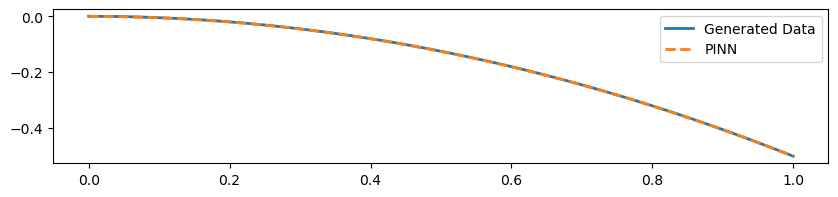

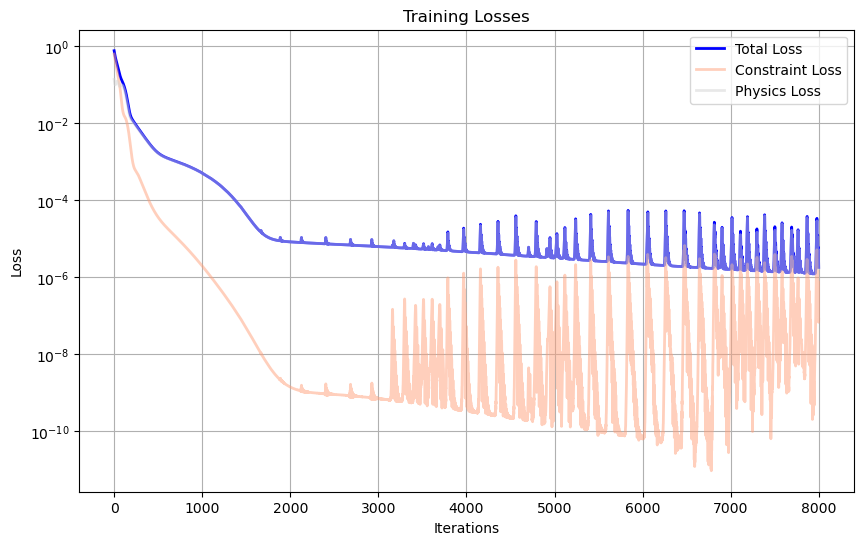

In [4]:

if __name__ == '__main__':
    ## ------------------ 各个 Network 的隐藏层相关的信息 --------------------##
    layers = [[1] + 3 * [10] + [1], [1] + 3 * [10] + [1], [1] + 3 * [10] + [1], [1] + 3 * [10] + [1]]

    # 相关参数的处理和分析
    # Generate data using the formula w = -M_epsilon * x^2 / (2 * EI)
    M_epsilon = 1.0  # Example value for M_epsilon
    EI = 1.0  # Example value for EI

    # ------------- 准备原始数据：训练的数据，验证的数据 ------------- #
    X_star = np.linspace(0, 1, 1001).reshape(-1, 1)
    # 这里是公式计算的具体数值，这里是解析解
    u_fem = -M_epsilon * X_star**2 / (2 * EI)  # Generate displacement data
    a_fem = -M_epsilon * X_star / (EI)  # Generate corner data
    k_fem = -M_epsilon * np.ones_like(X_star) / (EI)  # Generate curvature data

    # ------------- 这里的数据在整体的样本点库中随机的选取 50个 ------------- #
    N_f = 50
    idx = np.random.choice(X_star.shape[0], N_f, replace=False)
    X_train = X_star[idx, :]

    # ------------- 绘制整个杆上选取的数据点的可视化的图形 ------------- #
    # Plot training points
    plt.figure(figsize=(10, 1), dpi=300)
    plt.plot([0, 1], [0, 0], '^', markersize=10, label='Boundary')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.7, 2.0)
    plt.plot(X_train, np.zeros(X_train.shape), 'o', markersize=8, alpha=0.5, label='Random data')
    plt.yticks([])
    plt.xlabel('Location x')
    plt.legend(fontsize=12, ncol=2)
    # plt.savefig('beam1_model1_training_points_high_res.png', dpi=300, bbox_inches='tight')  # Save the plot
    plt.show()

    # ------------- 根据得到的理论解，确定各个边界条件的数值 ------------- #
    q = np.full_like(X_train, 0)
    X_uc = np.array([[0.0], [1.0]])
    u_c = np.array([[u_fem[0, 0]], [u_fem[-1, 0]]])
    X_ac = np.array([[0.0], [1.0]])
    a_c = np.array([[a_fem[0, 0]], [a_fem[-1, 0]]])
    X_kc = np.array([[0.0], [1.0]])
    k_c = np.array([[-k_fem[0, 0]], [-k_fem[-1, 0]]])

    # ------------- 模型数据的输入和相关参数的初始化分析 ------------- #
    model = PINN_model(layers, X_train, q, X_uc, u_c, X_ac, a_c, X_kc, k_c)
    # 模型开始训练，且训练的次数为8000次
    model.train(8000)

    # 模型训练完成后，进行相关的预测
    # 这里预测的点和训练的点完全不一样，训练只是采取其中少数的点，预测就是全部的点进行预测
    Q_pred, k_pred, a_pred, u_pred = model.predict(X_star)

    # ------------- 绘制预测的结果和真实的结果进行对比 ------------- #
    # 这里的数据进行分析的可视化
    plt.figure(figsize=(10, 2))
    plt.plot(X_star, u_fem, label='Generated Data', linewidth=2)
    plt.plot(X_star, u_pred, '--', label='PINN', linewidth=2)
    plt.legend()
    # plt.savefig('beam1_model1_generated_data_vs_PINN_high_res.png', dpi=300, bbox_inches='tight')  # Save the plot
    plt.show()

    # ------------- 除了绘制位移的数据，还可以绘制力矩、转角的图形对比 ------------- #
    

    # ------------- 绘制训练过程中损失值的可视化 ------------- #
    # Plot the loss values during training
    plt.figure(figsize=(10, 6))
    plt.plot(model.loss_log, label='Total Loss', linewidth=2, color='blue')
    plt.plot(model.loss_c_log, label='Constraint Loss', linewidth=2, color='lightsalmon', alpha=0.5)
    plt.plot(model.loss_f_log, label='Physics Loss', linewidth=2, color='lightgray', alpha=0.5)
    plt.yscale('log')  # Log scale for better visualization of loss reduction
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.legend()
    plt.grid(True)
    # plt.savefig('beam1_model1_training_losses_high_res.png', dpi=300, bbox_inches='tight')  # Save the plot
    plt.show()
